In [1]:
# import sys
# sys.path.append("/home/hoang/WorkSpace/centernet")
import pyrootutils
root = pyrootutils.setup_root(
    search_from='.',
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

from src.datamodules.voc_datamodule import VOCDataModule

/home/hoang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hoang/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/hoang/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/hoang/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
dtm = VOCDataModule("../data", year="2007", batch_size=4)
dtm.setup()

Using downloaded and verified file: ../data/VOCtrainval_06-Nov-2007.tar
Extracting ../data/VOCtrainval_06-Nov-2007.tar to ../data
Using downloaded and verified file: ../data/VOCtrainval_06-Nov-2007.tar
Extracting ../data/VOCtrainval_06-Nov-2007.tar to ../data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


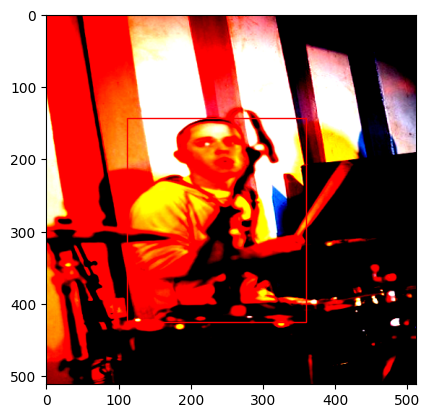

In [3]:
import matplotlib.pyplot as plt
import torch
from typing import Tuple

def plot_data(img: torch.Tensor, bboxes: torch.Tensor):
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
        plt.gca().add_patch(rect)
    plt.show()

for batch in dtm.train_dataloader():
    img, bboxes, labels = batch
    plot_data(img[0], bboxes[0])
    break

In [4]:
from src.models.centernet_module import CenterNet
from src.models.components.resnet import PoseResNet, BasicBlock

model = CenterNet(
    PoseResNet(
        BasicBlock,
        64,
        [2, 2, 2, 2],
        num_classes=21,
    ),
    optimizer=torch.optim.Adam,
    scheduler=torch.optim.lr_scheduler.StepLR,
)

PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [6]:
keypoints, offsets, sizes = model._get_object_params(bboxes, downsample=.25)

In [7]:
keypoints

[tensor([[59, 70]], dtype=torch.int32),
 tensor([[67, 57]], dtype=torch.int32),
 tensor([[65, 57]], dtype=torch.int32),
 tensor([[110,  12]], dtype=torch.int32)]

In [8]:
heatmaps = model._produce_gt_heatmap(keypoints, labels, model.num_classes, 128, 128)

In [9]:
heatmaps[0].shape

torch.Size([21, 128, 128])

In [10]:
offsets_map, sizes_map, masks = model._produce_gt_offset_and_size(keypoints, offsets, sizes, 128, 128)

In [20]:
from src.utils import decode

dec_bboxes, scores, classes = decode(heatmaps, offsets_map, sizes_map, .25, top_k=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


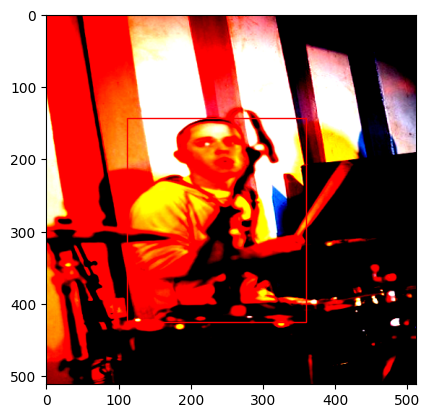

In [21]:
plot_data(img[0], dec_bboxes[0])

In [13]:
classes[0]

tensor([15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0])